# Multilayer perceptron for regression

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

## Creating artificial data for regression

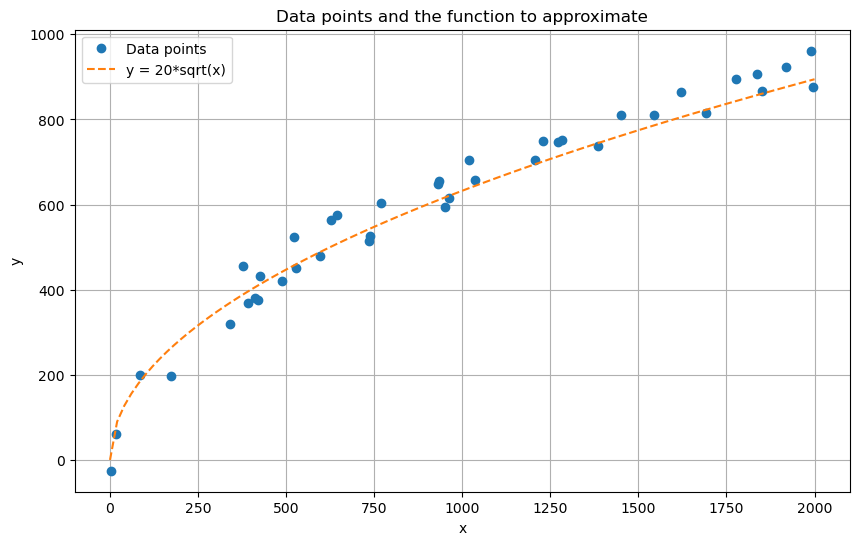

In [21]:
num_of_points = 40
x_values = torch.tensor(np.random.randint(0, 2000, size=(num_of_points,)), dtype=torch.float32)
deviation = torch.tensor(np.random.randint(-70, 70, size=(num_of_points,)), dtype=torch.float32)
y_values = 20*torch.sqrt(x_values) + deviation

x_values_line = torch.linspace(0, 2000, 100)
y_values_line = 20*torch.sqrt(x_values_line)

plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values, 'o', label = 'Data points')
plt.plot(x_values_line, y_values_line, label = 'y = 20*sqrt(x)', linestyle='--')
plt.title('Data points and the function to approximate')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

As we can see the function is not linear. So the linear regression would not work here. We need to use a multilayer perceptron that has a non-linear activation function.

# Defining the model

In [22]:
class MultilayerRegressor(nn.Module):
    def __init__(self, num_of_features):
        super().__init__()
        self.all_layers = nn.Sequential(
            nn.Linear(num_of_features, 32),
            nn.ReLU(),

            nn.Linear(32, 16),
            nn.ReLU(),

            nn.Linear(16, 1)
        )
    
    def forward(self, x):
        return self.all_layers(x)

# Normalize the data

In [23]:
x_mean = torch.mean(x_values)
x_std = torch.std(x_values)
x_values_normalized = (x_values - x_mean) / x_std
X = x_values_normalized.reshape(-1, 1)

y_mean = torch.mean(y_values)
y_std = torch.std(y_values)
y_values_normalized = (y_values - y_mean) / y_std
y = y_values_normalized.reshape(-1, 1)

# Defining Dataset and Dataloader

In [24]:
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    
    def __len__(self):
        return len(self.X)

In [25]:
dataset = MyDataset(X, y)

trainset, testset = torch.utils.data.random_split(dataset, [int(num_of_points*0.8), num_of_points - int(num_of_points*0.8)])

train_loader = DataLoader(trainset, batch_size=4, shuffle=True)
test_loader = DataLoader(testset, batch_size=4, shuffle=False)

/var/folders/b8/rcg993r57gn32qbmybxkp4280000gn/T/ipykernel_96495/740456371.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
/var/folders/b8/rcg993r57gn32qbmybxkp4280000gn/T/ipykernel_96495/740456371.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32)


# Training loop

In [26]:
def compute_loss(model, dataloader):
    total_loss = 0
    with torch.no_grad():
        for features, y in dataloader:
            y_pred = model(features)
            loss = F.mse_loss(y_pred, y)
            total_loss += loss

    return total_loss / len(dataloader)


In [38]:
torch.manual_seed(42)
num_epochs = 1000
learning_rate = 0.01

model = MultilayerRegressor(1)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

best_test_loss = np.inf
best_model = None

for epoch in range(num_epochs):
    model.train()

    for batch_idx, (features, y) in enumerate(train_loader):
        y_predicted = model(features)
        loss = F.mse_loss(y_predicted, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if not batch_idx % 200:
            ### LOGGING
            print(
                f"Epoch: {epoch+1:03d}/{num_epochs:03d}"
                f" | Batch {batch_idx:03d}/{len(train_loader):03d}"
                f" | Train Loss: {loss:.2f}"
            )
    
    model.eval()
    train_loss = compute_loss(model, train_loader)
    test_loss = compute_loss(model, test_loader)
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        best_model = model.state_dict()
    print(f"Epoch: {epoch+1:03d}/{num_epochs:03d} | Train Loss: {train_acc:.2f} | Test Loss: {test_acc:.2f}")

    


Epoch: 001/1000 | Batch 000/008 | Train Loss: 0.44
Epoch: 001/1000 | Train Loss: 0.02 | Test Loss: 0.04
Epoch: 002/1000 | Batch 000/008 | Train Loss: 0.77
Epoch: 002/1000 | Train Loss: 0.02 | Test Loss: 0.04
Epoch: 003/1000 | Batch 000/008 | Train Loss: 0.44
Epoch: 003/1000 | Train Loss: 0.02 | Test Loss: 0.04
Epoch: 004/1000 | Batch 000/008 | Train Loss: 0.38
Epoch: 004/1000 | Train Loss: 0.02 | Test Loss: 0.04
Epoch: 005/1000 | Batch 000/008 | Train Loss: 0.12
Epoch: 005/1000 | Train Loss: 0.02 | Test Loss: 0.04
Epoch: 006/1000 | Batch 000/008 | Train Loss: 0.28
Epoch: 006/1000 | Train Loss: 0.02 | Test Loss: 0.04
Epoch: 007/1000 | Batch 000/008 | Train Loss: 0.04
Epoch: 007/1000 | Train Loss: 0.02 | Test Loss: 0.04
Epoch: 008/1000 | Batch 000/008 | Train Loss: 0.55
Epoch: 008/1000 | Train Loss: 0.02 | Test Loss: 0.04
Epoch: 009/1000 | Batch 000/008 | Train Loss: 0.17
Epoch: 009/1000 | Train Loss: 0.02 | Test Loss: 0.04
Epoch: 010/1000 | Batch 000/008 | Train Loss: 0.07
Epoch: 010/10

In [39]:
print(f"Best test loss: {best_test_loss:.2f}")

Best test loss: 0.04


# Visualize the regrresion line

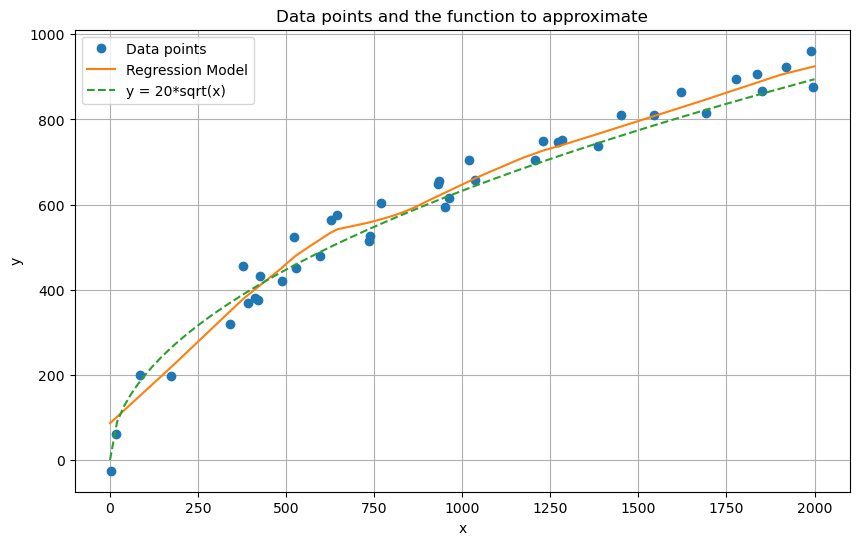

In [40]:
with torch.no_grad():
    X = x_values_line.reshape(-1, 1)
    X_normalized = (X - x_mean) / x_std
    y_pred_normalized = model(X_normalized)

y_pred = y_pred_normalized * y_std + y_mean

plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values, 'o', label = 'Data points')
plt.plot(x_values_line, y_pred, label = 'Regression Model')
plt.plot(x_values_line, y_values_line, label = 'y = 20*sqrt(x)', linestyle='--')
plt.title('Data points and the function to approximate')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

Regression Model performed well on the data. We can see that the regression line is able to capture the non-linear relationship between the data.